In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.cm as cm
import time 
from scipy.stats import kurtosis
from itertools import product
from collections import defaultdict
import scipy.sparse as sps
from scipy.linalg import pinv
from sklearn.model_selection import  GridSearchCV,cross_validate, train_test_split,learning_curve
from sklearn.neural_network import MLPClassifier
import sklearn.metrics
from sklearn.cluster import KMeans
from sklearn.mixture import GaussianMixture
from sklearn.decomposition import PCA
from sklearn.decomposition import FastICA
from sklearn.random_projection import GaussianRandomProjection
from sklearn.feature_selection import SelectKBest
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics.cluster import normalized_mutual_info_score
from sklearn.metrics import silhouette_samples, silhouette_score
from sklearn import preprocessing
from sklearn import metrics
from sklearn.random_projection import GaussianRandomProjection as GRP, SparseRandomProjection
from sklearn.ensemble import RandomForestClassifier as RFC
from sklearn.metrics.pairwise import pairwise_distances
from sklearn.decomposition import FactorAnalysis 
from sklearn.decomposition import TruncatedSVD as SVD

In [2]:
def label_race(row):
    if row['count'] >= 145 :
        return 1
    else:
        return 0

def prep_clean_traindata(df):
    df['target'] = df.apply(lambda row: label_race(row), axis=1)
    df = df.drop(['count','datetime'], axis='columns')
    df['season'] = df['season'].astype('str')
    df['weather'] = df['weather'].astype('str')
    df['holiday'] = df['holiday'].astype('bool')
    df['workingday'] = df['workingday'].astype('bool')
    data0 = df.loc[df['target'] == 1][:1000]
    data1 = df.loc[df['target'] == 0][:1000]    
    result = pd.concat([data0, data1])
    return result

def prep_clean_testdata(df):
    df = df.drop(['datetime'], axis='columns')
    df['season'] = df['season'].astype('str')
    df['weather'] = df['weather'].astype('str')
    df['holiday'] = df['holiday'].astype('bool')
    df['workingday'] = df['workingday'].astype('bool')
    df = df[:1000]
    return df

In [48]:
train = pd.read_csv('./bike-sharing-demand/train.csv', header = 0, sep = ",")
test = pd.read_csv('./bike-sharing-demand/test.csv', header = 0, sep = ",")

# clean and prep tables
train_df = prep_clean_traindata(train)
test_df = prep_clean_testdata(test)

# prep training and testing
X = train_df.drop(['target'], axis='columns')
y = train_df['target']
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42, stratify=y)

kmeans run time: 1.4 [s]


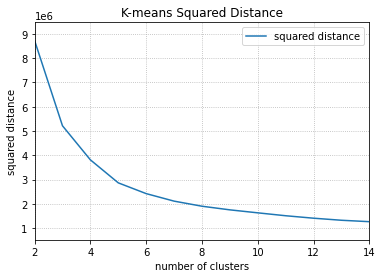

In [12]:
#K means clustering
range_n_clusters = list(range(2,15))
kmeans_distance = []
kmeans_silhouette = []
kmeans_homogeneity = []
kmeans_completeness = []
kmeans_NMI = []
start = time.perf_counter() 
for n_clusters in range_n_clusters:
    cluster = KMeans(n_clusters=n_clusters, random_state=10).fit(X_train)
    kmeans_distance.append(cluster.inertia_)    
    cluster_labels = cluster.labels_
    kmeans_silhouette.append(silhouette_score(X_train, cluster_labels))
    kmeans_homogeneity.append(metrics.homogeneity_score(y_train, cluster_labels))
    kmeans_completeness.append(metrics.completeness_score(y_train, cluster_labels))
    kmeans_NMI.append(normalized_mutual_info_score(y_train, cluster_labels))
end = time.perf_counter() 
print("kmeans run time: %.1f [s]" % (end-start))

plt.figure()
plt.title('K-means Squared Distance')
plt.ylabel('squared distance')
plt.xlabel('number of clusters')
plt.grid(linestyle='dotted')
plt.plot(range_n_clusters, kmeans_distance, label = 'squared distance')
plt.legend()
plt.margins(0,0.1)
plt.show()
plt.close()

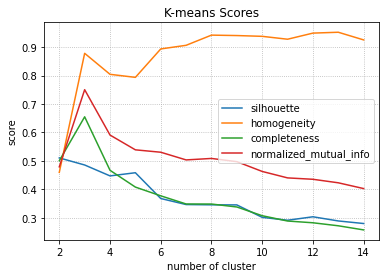

In [13]:
plt.figure()
plt.title('K-means Scores')
plt.ylabel('score')
plt.xlabel('number of cluster')
plt.plot(range_n_clusters, kmeans_silhouette, label='silhouette')
plt.plot(range_n_clusters, kmeans_homogeneity, label='homogeneity')
plt.plot(range_n_clusters, kmeans_completeness, label='completeness')
plt.plot(range_n_clusters, kmeans_NMI, label='normalized_mutual_info')
plt.grid(linestyle='dotted')
plt.legend()
plt.show()
plt.close()

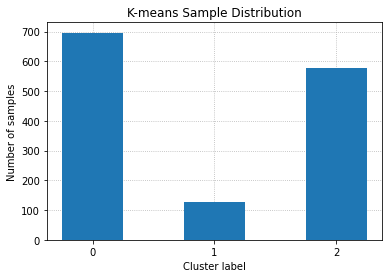

In [11]:
k = 3
cluster = KMeans(n_clusters=k, random_state=10).fit(X_train)
cluster_labels = cluster.labels_
plt.figure()
plt.title('K-means Sample Distribution')
plt.hist(cluster.labels_, bins=np.arange(0, k + 1) - 0.5, rwidth=0.5, zorder=2)
plt.xticks(np.arange(0, k))
plt.xlabel('Cluster label')
plt.ylabel('Number of samples')
plt.grid(linestyle='dotted')
plt.show()
plt.close()

EM run time: 1.8 [s]


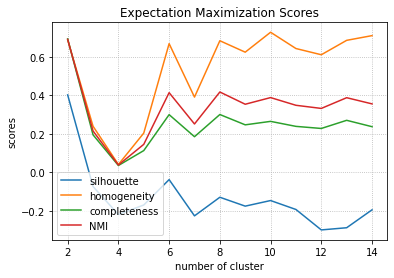

In [14]:
#Expectation Maximization
range_n_clusters = list(range(2,15))
EM_silhouette = []
EM_homogeneity = []
EM_completeness = []
EM_NMI = []
EM_AIC = []
EM_BIC = []
start = time.perf_counter() 
for n_clusters  in range_n_clusters :
    cluster = GaussianMixture(n_components=n_clusters, random_state=10).fit(X_train) 
    cluster_labels = cluster.predict(X_train)
    EM_silhouette.append(silhouette_score(X_train, cluster_labels))
    EM_homogeneity.append(metrics.homogeneity_score(y_train, cluster_labels))
    EM_completeness.append(metrics.completeness_score(y_train, cluster_labels))
    EM_NMI.append(normalized_mutual_info_score(y_train, cluster_labels))
    EM_AIC.append(cluster.aic(X_train)) 
    EM_BIC.append(cluster.bic(X_train))  
end = time.perf_counter() 
print("EM run time: %.1f [s]" % (end-start))    
    
plt.figure()
plt.title('Expectation Maximization Scores')
plt.plot(range_n_clusters, EM_silhouette, label="silhouette")
plt.plot(range_n_clusters, EM_homogeneity, label="homogeneity")
plt.plot(range_n_clusters, EM_completeness, label="completeness")
plt.plot(range_n_clusters, EM_NMI, label="NMI")
plt.ylabel('scores')
plt.xlabel('number of cluster')
plt.grid(linestyle='dotted')
plt.legend()
plt.show()
plt.close()

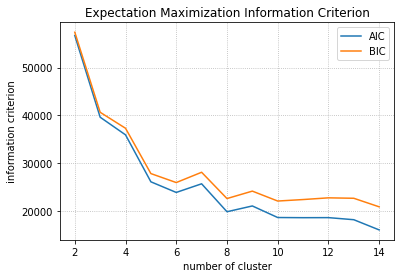

In [15]:
plt.figure()
plt.title('Expectation Maximization Information Criterion')
plt.plot(range_n_clusters, EM_AIC, label="AIC")
plt.plot(range_n_clusters, EM_BIC, label="BIC")
plt.ylabel('information criterion')
plt.xlabel('number of cluster')
plt.grid(linestyle='dotted')
plt.legend()
plt.show()
plt.close()

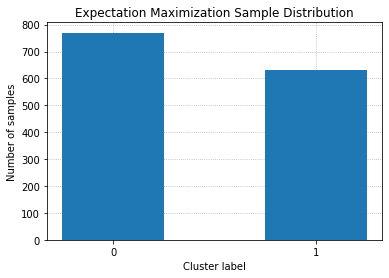

In [16]:
#visulization of clusters
k = 2
cluster = GaussianMixture(n_components=k, random_state=10).fit(X_train)
cluster_labels = cluster.predict(X_train)
plt.figure()
plt.title('Expectation Maximization Sample Distribution')
plt.hist(cluster_labels, bins=np.arange(0, k + 1) - 0.5, rwidth=0.5, zorder=2)
plt.xticks(np.arange(0, k))
plt.xlabel('Cluster label')
plt.ylabel('Number of samples')
plt.grid(linestyle='dotted')
plt.show()
plt.close()

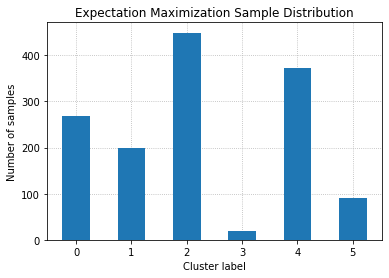

In [20]:
#visulization of clusters
k = 6
cluster = GaussianMixture(n_components=k, random_state=10).fit(X_train)
cluster_labels = cluster.predict(X_train)
plt.figure()
plt.title('Expectation Maximization Sample Distribution')
plt.hist(cluster_labels, bins=np.arange(0, k + 1) - 0.5, rwidth=0.5, zorder=2)
plt.xticks(np.arange(0, k))
plt.xlabel('Cluster label')
plt.ylabel('Number of samples')
plt.grid(linestyle='dotted')
plt.show()
plt.close()

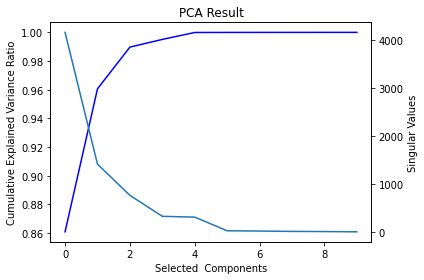

PCA run time: 0.1 [s]


In [21]:
#################### PCA #############################
##explaination ratio to decide which component ###
start = time.perf_counter() 
pca = PCA(random_state=10).fit(X_train) #for all components
sum_var = np.cumsum(pca.explained_variance_ratio_)
fig, ax1 = plt.subplots()
plt.title('PCA Result')
# Make the y-axis label, ticks and tick labels match the line color.
ax1.set_ylabel('Cumulative Explained Variance Ratio')
ax1.tick_params('y')
ax1.plot(list(range(len(pca.explained_variance_ratio_))), sum_var, 'b-')
ax1.set_xlabel('Selected  Components')

ax2 = ax1.twinx()
ax2.plot(list(range(len(pca.singular_values_))), pca.singular_values_)
ax2.set_ylabel('Singular Values')
ax2.tick_params('y')
fig.tight_layout()
plt.show()
end = time.perf_counter() 
print("PCA run time: %.1f [s]" % (end-start))  

/Users/zhujingyao/Anaconda/anaconda3/envs/mlhw1/lib/python3.8/site-packages/sklearn/decomposition/_fastica.py:116: ConvergenceWarning: FastICA did not converge. Consider increasing tolerance or the maximum number of iterations.
  warnings.warn(


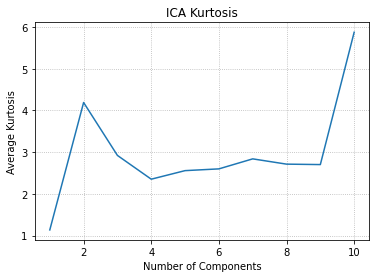

ICA run time: 0.3 [s]


In [23]:
############## ICA #################
start = time.perf_counter() 
dims = list(range(1,X_train.shape[1]+1))
ica = FastICA(random_state=10)
kurt = {}

for dim in dims:
    ica.set_params(n_components=dim)
    tmp = ica.fit_transform(X_train)
    tmp = pd.DataFrame(tmp)
    tmp = tmp.kurt(axis=0)
    kurt[dim] = tmp.abs().mean()


plt.figure()
plt.title("ICA Kurtosis")
plt.xlabel("Number of Components")
plt.ylabel("Average Kurtosis")
plt.plot(kurt.keys(), kurt.values())
plt.grid(linestyle='dotted')
plt.show()
plt.close()

end = time.perf_counter() 
print("ICA run time: %.1f [s]" % (end-start))

In [ ]:
############### random projection ####################
##########low error############
start = time.perf_counter() 
def reconstruction_error(projections, x):
    w = projections.components_
    if sps.issparse(w):
        w = w.todense()
    p = pinv(w)
    reconstructed = ((p@w)@(x.T)).T  # Unproject projected data
    errors = np.square(x-reconstructed)
    return np.nanmean(errors) 
    

dims =  list(range(1,X_train_1.shape[1]+1))   
tmp = defaultdict(dict)
for i,dim in product(range(10),dims):
    rp = SparseRandomProjection(random_state=10, n_components=dim)
    rp = rp.fit(X_train_1)
    tmp[dim][i] = reconstruction_error(rp, X_train_1)
tmp = pd.DataFrame(tmp).T

plt.figure()

plt.ylabel('error')
plt.xlabel('number of components')
plt.title("Random Projection Reconstruction Error")
plt.plot(dims,tmp)
plt.grid()
plt.show()
plt.close()
end = time.perf_counter() 
print("random projection run time: %.1f [s]" % (end-start))    

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


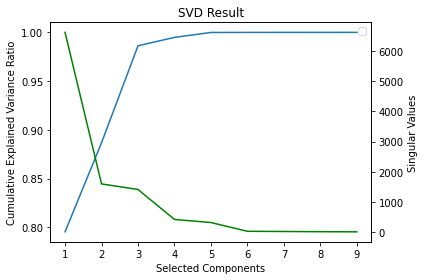

svd run time: 0.2 [s]


In [26]:
################### Singular Value Decomposition #########################
start = time.perf_counter() 
dims =  list(range(1,X_train.shape[1])) 
svd = SVD(random_state=10)

for dim in dims:
    svd.set_params(n_components=dim)
    svd.fit_transform(X_train)
    sv = svd.singular_values_
    sum_var = np.cumsum(svd.explained_variance_ratio_)

fig, ax1 = plt.subplots()
plt.title('SVD Result')
ax1.plot(dims, sum_var)
ax1.set_xlabel('Selected Components')
ax1.set_ylabel('Cumulative Explained Variance Ratio')
ax1.tick_params('y')

ax2 = ax1.twinx()
ax2.plot(dims, sv,color = 'g')
ax2.set_ylabel('Singular Values')
ax2.tick_params('y')
fig.tight_layout()
plt.legend()
plt.show()
plt.close()
end = time.perf_counter() 
print("svd run time: %.1f [s]" % (end-start)) 

In [34]:
###################### Dimension Reduction ##################################

###########K means with dimension reduction##########

range_n_clusters = list(range(2,25))
kmeans_distance = []
kmeans_distance_pca = []
kmeans_distance_ica = []
kmeans_distance_rp = []
kmeans_distance_svd = []
kmeans_silhouette = []
kmeans_silhouette_pca = []
kmeans_silhouette_ica = []
kmeans_silhouette_rp = []
kmeans_silhouette_svd = []
kmeans_homogeneity = []
kmeans_homogeneity_pca = []
kmeans_homogeneity_ica = []
kmeans_homogeneity_rp = []
kmeans_homogeneity_svd = []
kmeans_completeness = []
kmeans_completeness_pca = []
kmeans_completeness_ica = []
kmeans_completeness_rp = []
kmeans_completeness_svd = []

for n_clusters in list(range_n_clusters):
    
    X_pca = PCA(n_components=2,random_state=10).fit_transform(X_train)
    X_ica = FastICA(n_components=2,random_state=10).fit_transform(X_train)
    X_rp = SparseRandomProjection(n_components=20,random_state=10).fit_transform(X_train_1)
    X_svd = SVD(n_components=3,random_state=10).fit_transform(X_train)
    cluster = KMeans(n_clusters=n_clusters, random_state=10).fit(X_train)
    cluster_pca = KMeans(n_clusters=n_clusters, random_state=10).fit(X_pca)
    cluster_ica = KMeans(n_clusters=n_clusters, random_state=10).fit(X_ica)
    cluster_rp = KMeans(n_clusters=n_clusters, random_state=10).fit(X_rp)
    cluster_svd = KMeans(n_clusters=n_clusters, random_state=10).fit(X_svd)
    kmeans_distance.append(cluster.inertia_)
    kmeans_distance_pca.append(cluster_pca.inertia_)
    kmeans_distance_ica.append(cluster_ica.inertia_)    
    kmeans_distance_rp.append(cluster_rp.inertia_)
    kmeans_distance_svd.append(cluster_svd.inertia_)   
    kmeans_labels = cluster.labels_
    kmeans_labels_pca = cluster_pca.labels_
    kmeans_labels_ica = cluster_ica.labels_
    kmeans_labels_rp = cluster_rp.labels_
    kmeans_labels_svd = cluster_svd.labels_
    kmeans_silhouette.append(silhouette_score(X_train, kmeans_labels))
    kmeans_silhouette_pca.append(silhouette_score(X_pca, kmeans_labels_pca))
    kmeans_silhouette_ica.append(silhouette_score(X_ica, kmeans_labels_ica))
    kmeans_silhouette_rp.append(silhouette_score(X_rp, kmeans_labels_rp))
    kmeans_silhouette_svd.append(silhouette_score(X_svd, kmeans_labels_svd))
    kmeans_homogeneity.append(metrics.homogeneity_score(y_train, kmeans_labels))
    kmeans_homogeneity_pca.append(metrics.homogeneity_score(y_train, kmeans_labels_pca))
    kmeans_homogeneity_ica.append(metrics.homogeneity_score(y_train, kmeans_labels_ica))
    kmeans_homogeneity_rp.append(metrics.homogeneity_score(y_train, kmeans_labels_rp))
    kmeans_homogeneity_svd.append(metrics.homogeneity_score(y_train, kmeans_labels_svd))
    kmeans_completeness.append(metrics.completeness_score(y_train, kmeans_labels))
    kmeans_completeness_pca.append(metrics.completeness_score(y_train, kmeans_labels_pca))
    kmeans_completeness_ica.append(metrics.completeness_score(y_train, kmeans_labels_ica))
    kmeans_completeness_rp.append(metrics.completeness_score(y_train, kmeans_labels_rp))
    kmeans_completeness_svd.append(metrics.completeness_score(y_train, kmeans_labels_svd))

/Users/zhujingyao/Anaconda/anaconda3/envs/mlhw1/lib/python3.8/site-packages/sklearn/random_projection.py:376: DataDimensionalityWarning: The number of components is higher than the number of features: n_features < n_components (3 < 20).The dimensionality of the problem will not be reduced.
  warnings.warn(
/Users/zhujingyao/Anaconda/anaconda3/envs/mlhw1/lib/python3.8/site-packages/sklearn/random_projection.py:376: DataDimensionalityWarning: The number of components is higher than the number of features: n_features < n_components (3 < 20).The dimensionality of the problem will not be reduced.
  warnings.warn(
/Users/zhujingyao/Anaconda/anaconda3/envs/mlhw1/lib/python3.8/site-packages/sklearn/random_projection.py:376: DataDimensionalityWarning: The number of components is higher than the number of features: n_features < n_components (3 < 20).The dimensionality of the problem will not be reduced.
  warnings.warn(
/Users/zhujingyao/Anaconda/anaconda3/envs/mlhw1/lib/python3.8/site-packages/

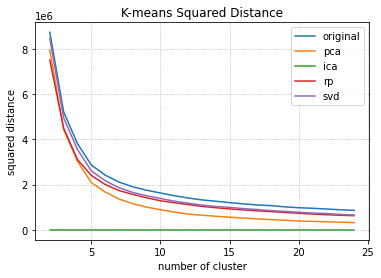

In [35]:
    #SSE
plt.figure()
plt.title('K-means Squared Distance')
plt.plot(range_n_clusters, kmeans_distance, label="original")
plt.plot(range_n_clusters, kmeans_distance_pca, label="pca")
plt.plot(range_n_clusters, kmeans_distance_ica, label="ica")
plt.plot(range_n_clusters, kmeans_distance_rp, label="rp")
plt.plot(range_n_clusters, kmeans_distance_svd, label="svd")
plt.xlabel('number of cluster')
plt.ylabel('squared distance')
plt.grid(linestyle='dotted')
plt.legend()
plt.show()
plt.close()

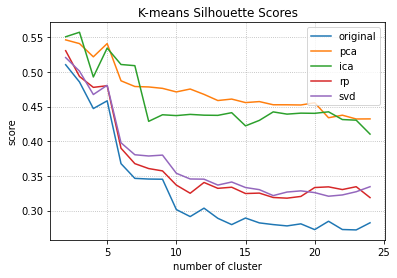

In [36]:
    #silhouette
plt.figure()
plt.title('K-means Silhouette Scores')
plt.plot(range_n_clusters, kmeans_silhouette, label="original")
plt.plot(range_n_clusters, kmeans_silhouette_pca, label="pca")
plt.plot(range_n_clusters, kmeans_silhouette_ica, label="ica")
plt.plot(range_n_clusters, kmeans_silhouette_rp, label="rp")
plt.plot(range_n_clusters, kmeans_silhouette_svd, label="svd")
plt.xlabel('number of cluster')
plt.ylabel('score')
plt.grid(linestyle='dotted')
plt.legend()
plt.show()
plt.close()

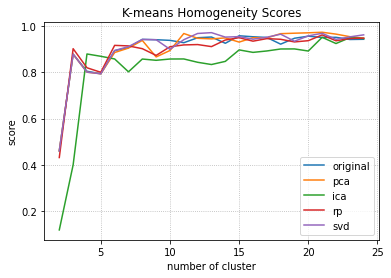

In [37]:
    #homogeneity
plt.figure()
plt.title('K-means Homogeneity Scores')
plt.plot(range_n_clusters, kmeans_homogeneity, label="original")
plt.plot(range_n_clusters, kmeans_homogeneity_pca, label="pca")
plt.plot(range_n_clusters, kmeans_homogeneity_ica, label="ica")
plt.plot(range_n_clusters, kmeans_homogeneity_rp, label="rp")
plt.plot(range_n_clusters, kmeans_homogeneity_svd, label="svd")
plt.xlabel('number of cluster')
plt.ylabel('score')
plt.grid(linestyle='dotted')
plt.legend()
plt.show()
plt.close()

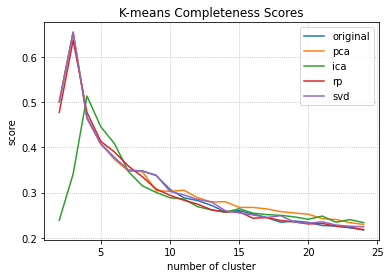

In [38]:
    #completeness
plt.figure()
plt.title('K-means Completeness Scores')
plt.plot(range_n_clusters, kmeans_completeness, label="original")
plt.plot(range_n_clusters, kmeans_completeness_pca, label="pca")
plt.plot(range_n_clusters, kmeans_completeness_ica, label="ica")
plt.plot(range_n_clusters, kmeans_completeness_rp, label="rp")
plt.plot(range_n_clusters, kmeans_completeness_svd, label="svd")
plt.xlabel('number of cluster')
plt.ylabel('score')
plt.grid(linestyle='dotted')
plt.legend()
plt.show()
plt.close()

In [39]:
######## EM dimension reduction ###########
range_n_clusters = list(range(2,25))
em_aic = []
em_aic_pca = []
em_aic_ica = []
em_aic_rp = []
em_aic_svd = []
em_bic = []
em_bic_pca = []
em_bic_ica = []
em_bic_rp = []
em_bic_svd = []
em_silhouette = []
em_silhouette_pca = []
em_silhouette_ica = []
em_silhouette_rp = []
em_silhouette_svd = []
em_homogeneity = []
em_homogeneity_pca = []
em_homogeneity_ica = []
em_homogeneity_rp = []
em_homogeneity_svd = []
em_completeness = []
em_completeness_pca = []
em_completeness_ica = []
em_completeness_rp = []
em_completeness_svd = []

for index, n_clusters in enumerate(range_n_clusters):
    
    X_pca = PCA(n_components=2,random_state=10).fit_transform(X_train)
    X_ica = FastICA(n_components=2,random_state=10).fit_transform(X_train)
    X_rp = SparseRandomProjection(n_components=20,random_state=10).fit_transform(X_train)
    X_svd = SVD(n_components=3,random_state=10).fit_transform(X_train)
    cluster =  GaussianMixture(n_components=n_clusters, random_state=10).fit(X_train)
    cluster_pca =  GaussianMixture(n_components=n_clusters, random_state=10).fit(X_pca)
    cluster_ica =  GaussianMixture(n_components=n_clusters, random_state=10).fit(X_ica)
    cluster_rp =  GaussianMixture(n_components=n_clusters, random_state=10).fit(X_rp)
    cluster_svd =  GaussianMixture(n_components=n_clusters, random_state=10).fit(X_svd)
    em_labels =     cluster.predict(X_train)
    em_labels_pca = cluster_pca.predict(X_pca)
    em_labels_ica = cluster_ica.predict(X_ica)
    em_labels_rp =  cluster_rp.predict(X_rp)
    em_labels_svd = cluster_svd.predict(X_svd)
    em_bic.append(cluster.bic(X_train))
    em_bic_pca.append(cluster_pca.bic(X_pca))
    em_bic_ica.append(cluster_ica.bic(X_ica))    
    em_bic_rp.append(cluster_rp.bic(X_rp))
    em_bic_svd.append(cluster_svd.bic(X_svd))
    em_aic.append(cluster.aic(X_train))
    em_aic_pca.append(cluster_pca.aic(X_pca))
    em_aic_ica.append(cluster_ica.aic(X_ica))    
    em_aic_rp.append(cluster_rp.aic(X_rp))
    em_aic_svd.append(cluster_svd.aic(X_svd)) 
    em_silhouette.append(silhouette_score(X_train, em_labels))
    em_silhouette_pca.append(silhouette_score(X_pca, em_labels_pca))
    em_silhouette_ica.append(silhouette_score(X_ica, em_labels_ica))
    em_silhouette_rp.append(silhouette_score(X_rp, em_labels_rp))
    em_silhouette_svd.append(silhouette_score(X_svd, em_labels_svd))
    em_homogeneity.append(metrics.homogeneity_score(y_train, em_labels))
    em_homogeneity_pca.append(metrics.homogeneity_score(y_train, em_labels_pca))
    em_homogeneity_ica.append(metrics.homogeneity_score(y_train, em_labels_ica))
    em_homogeneity_rp.append(metrics.homogeneity_score(y_train, em_labels_rp))
    em_homogeneity_svd.append(metrics.homogeneity_score(y_train, em_labels_svd))
    em_completeness.append(metrics.completeness_score(y_train, em_labels))
    em_completeness_pca.append(metrics.completeness_score(y_train, em_labels_pca))
    em_completeness_ica.append(metrics.completeness_score(y_train, em_labels_ica))
    em_completeness_rp.append(metrics.completeness_score(y_train, em_labels_rp))
    em_completeness_svd.append(metrics.completeness_score(y_train, em_labels_svd))

/Users/zhujingyao/Anaconda/anaconda3/envs/mlhw1/lib/python3.8/site-packages/sklearn/random_projection.py:376: DataDimensionalityWarning: The number of components is higher than the number of features: n_features < n_components (10 < 20).The dimensionality of the problem will not be reduced.
  warnings.warn(
/Users/zhujingyao/Anaconda/anaconda3/envs/mlhw1/lib/python3.8/site-packages/sklearn/random_projection.py:376: DataDimensionalityWarning: The number of components is higher than the number of features: n_features < n_components (10 < 20).The dimensionality of the problem will not be reduced.
  warnings.warn(
/Users/zhujingyao/Anaconda/anaconda3/envs/mlhw1/lib/python3.8/site-packages/sklearn/random_projection.py:376: DataDimensionalityWarning: The number of components is higher than the number of features: n_features < n_components (10 < 20).The dimensionality of the problem will not be reduced.
  warnings.warn(
/Users/zhujingyao/Anaconda/anaconda3/envs/mlhw1/lib/python3.8/site-packag

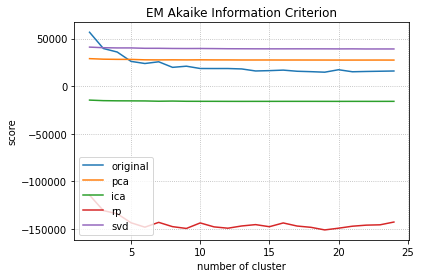

In [40]:
    #AIC
    #the lower the better
plt.figure()
plt.title('EM Akaike Information Criterion')
plt.plot(range_n_clusters, em_aic, label="original")
plt.plot(range_n_clusters, em_aic_pca, label="pca")
plt.plot(range_n_clusters, em_aic_ica, label="ica")
plt.plot(range_n_clusters, em_aic_rp, label="rp")
plt.plot(range_n_clusters,em_aic_svd, label="svd")
plt.xlabel('number of cluster')
plt.ylabel('score')
plt.grid(linestyle='dotted')
plt.legend()
plt.show()
plt.close()

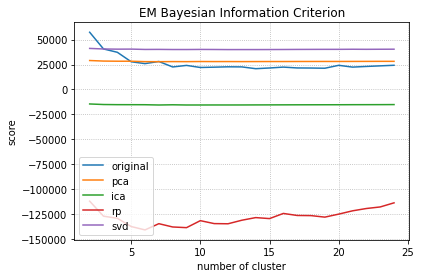

In [41]:
    #BIC
    #the lower the better
plt.figure()
plt.title('EM Bayesian Information Criterion')
plt.plot(range_n_clusters, em_bic, label="original")
plt.plot(range_n_clusters, em_bic_pca, label="pca")
plt.plot(range_n_clusters, em_bic_ica, label="ica")
plt.plot(range_n_clusters, em_bic_rp, label="rp")
plt.plot(range_n_clusters,em_bic_svd, label="svd")
plt.xlabel('number of cluster')
plt.ylabel('score')
plt.grid(linestyle='dotted')
plt.legend()
plt.show()
plt.close()

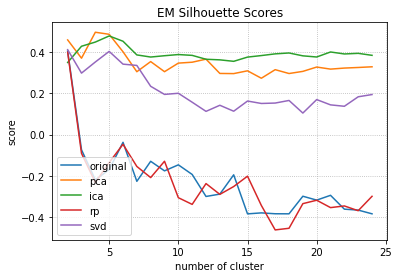

In [42]:
    #silhouette
plt.figure()
plt.title('EM Silhouette Scores')
plt.plot(range_n_clusters, em_silhouette, label="original")
plt.plot(range_n_clusters, em_silhouette_pca, label="pca")
plt.plot(range_n_clusters, em_silhouette_ica, label="ica")
plt.plot(range_n_clusters, em_silhouette_rp, label="rp")
plt.plot(range_n_clusters, em_silhouette_svd, label="svd")
plt.xlabel('number of cluster')
plt.ylabel('score')
plt.grid(linestyle='dotted')
plt.legend()
plt.show()
plt.close()

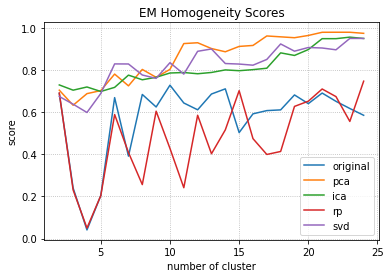

In [43]:
    #homogeneity
plt.figure()
plt.title('EM Homogeneity Scores')
plt.plot(range_n_clusters, em_homogeneity, label="original")
plt.plot(range_n_clusters, em_homogeneity_pca, label="pca")
plt.plot(range_n_clusters, em_homogeneity_ica, label="ica")
plt.plot(range_n_clusters, em_homogeneity_rp, label="rp")
plt.plot(range_n_clusters, em_homogeneity_svd, label="svd")
plt.xlabel('number of cluster')
plt.ylabel('score')
plt.grid(linestyle='dotted')
plt.legend()
plt.show()
plt.close()

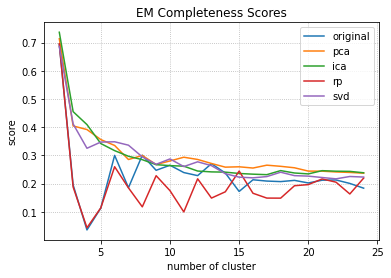

In [44]:
    #completeness
plt.figure()
plt.title('EM Completeness Scores')
plt.plot(range_n_clusters, em_completeness, label="original")
plt.plot(range_n_clusters, em_completeness_pca, label="pca")
plt.plot(range_n_clusters, em_completeness_ica, label="ica")
plt.plot(range_n_clusters, em_completeness_rp, label="rp")
plt.plot(range_n_clusters, em_completeness_svd, label="svd")
plt.xlabel('number of cluster')
plt.ylabel('score')
plt.grid(linestyle='dotted')
plt.legend()
plt.show()
plt.close()

/Users/zhujingyao/Anaconda/anaconda3/envs/mlhw1/lib/python3.8/site-packages/sklearn/neural_network/_multilayer_perceptron.py:692: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(
/Users/zhujingyao/Anaconda/anaconda3/envs/mlhw1/lib/python3.8/site-packages/sklearn/neural_network/_multilayer_perceptron.py:692: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(
/Users/zhujingyao/Anaconda/anaconda3/envs/mlhw1/lib/python3.8/site-packages/sklearn/neural_network/_multilayer_perceptron.py:692: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(
/Users/zhujingyao/Anaconda/anaconda3/envs/mlhw1/lib/python3.8/site-packages/sklearn/neural_network/_multilayer_perceptron.py:692: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached 

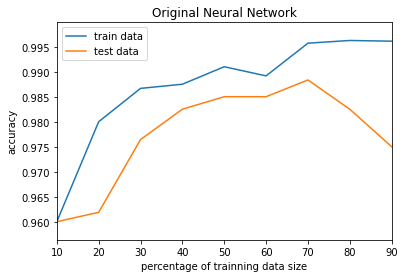

In [49]:
#####################Neural Network#####################
###### original ###########
#learning curve for accuracy 
train=[]
test=[]
size = list(np.array(list(range(1,10)))*10)
nn = MLPClassifier(random_state = 100, alpha = 0.1, activation = 'relu')
for i in range(1,10):
    # Split dataset into training set and test set 
    X_train_1, X_test_1, Y_train_1, Y_test_1 = train_test_split(X, y, test_size=1-i*10/100,shuffle = True, random_state=100)
    nn = nn.fit(X_train_1, Y_train_1)
    train_predict = nn.predict(X_train_1)
    test_predict = nn.predict(X_test_1)
    train.append(metrics.accuracy_score(Y_train_1, train_predict))
    test.append(metrics.accuracy_score(Y_test_1, test_predict))
    
train_df = pd.DataFrame(train, index = list(range(1,10)))
test_df = pd.DataFrame(test, index = list(range(1,10)))

plt.figure()
plt.title('Original Neural Network')
plt.plot(size,train, label="train data")
plt.plot(size,test, label="test data")
plt.ylabel('accuracy')
plt.xlabel('percentage of trainning data size')
plt.legend()
plt.margins(0,0.1)
plt.show()
plt.close()

In [51]:
###### dimension reduction tuning ###########
#learning curve for accuracy 
train_pca = []
train_ica = []
train_rca = []
train_svd = []
size = list(range(2, X_train.shape[1]))
clf = MLPClassifier(random_state = 100, alpha = 0.1, activation = 'relu')
start = time.perf_counter() 
for n in size:
    X_pca = PCA(n_components=n,random_state=100).fit_transform(X_train)
    nn_pca = clf.fit(X_pca, y_train)
    p_pca = nn_pca.predict(X_pca)       
    train_pca.append(metrics.accuracy_score(y_train, p_pca))
end = time.perf_counter() 
print("pca run time: %.1f [s]" % (end-start))
    
start = time.perf_counter() 
for n in size:
    X_svd = SVD(n_components=n,random_state=10).fit_transform(X_train)
    nn_svd = clf.fit(X_svd, y_train)
    p_svd = nn_svd.predict(X_svd)
    train_svd.append(metrics.accuracy_score(y_train, p_svd))
end = time.perf_counter() 
print("svd run time: %.1f [s]" % (end-start))
    
start = time.perf_counter()     
for n in size:
    X_ica = FastICA(n_components=n,random_state=10).fit_transform(X_train)
    nn_ica = clf.fit(X_ica, y_train)
    p_ica = nn_ica.predict(X_ica)
    train_ica.append(metrics.accuracy_score(y_train, p_ica))
end = time.perf_counter() 
print("ica run time: %.1f [s]" % (end-start))
    
start = time.perf_counter()   
for n in size:
    X_srp = SparseRandomProjection(n_components=n,random_state=10).fit_transform(X_train)
    nn_srp = clf.fit(X_srp, y_train)
    p_srp = nn_srp.predict(X_srp)
    train_rca.append(metrics.accuracy_score(y_train, p_srp))
end = time.perf_counter() 
print("srp run time: %.1f [s]" % (end-start))

pca run time: 2.2 [s]


/Users/zhujingyao/Anaconda/anaconda3/envs/mlhw1/lib/python3.8/site-packages/sklearn/neural_network/_multilayer_perceptron.py:692: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(
/Users/zhujingyao/Anaconda/anaconda3/envs/mlhw1/lib/python3.8/site-packages/sklearn/neural_network/_multilayer_perceptron.py:692: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(
/Users/zhujingyao/Anaconda/anaconda3/envs/mlhw1/lib/python3.8/site-packages/sklearn/neural_network/_multilayer_perceptron.py:692: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(
/Users/zhujingyao/Anaconda/anaconda3/envs/mlhw1/lib/python3.8/site-packages/sklearn/neural_network/_multilayer_perceptron.py:692: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached 

svd run time: 5.2 [s]


/Users/zhujingyao/Anaconda/anaconda3/envs/mlhw1/lib/python3.8/site-packages/sklearn/neural_network/_multilayer_perceptron.py:692: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(
/Users/zhujingyao/Anaconda/anaconda3/envs/mlhw1/lib/python3.8/site-packages/sklearn/neural_network/_multilayer_perceptron.py:692: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(
/Users/zhujingyao/Anaconda/anaconda3/envs/mlhw1/lib/python3.8/site-packages/sklearn/neural_network/_multilayer_perceptron.py:692: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(
/Users/zhujingyao/Anaconda/anaconda3/envs/mlhw1/lib/python3.8/site-packages/sklearn/neural_network/_multilayer_perceptron.py:692: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached 

ica run time: 5.3 [s]


/Users/zhujingyao/Anaconda/anaconda3/envs/mlhw1/lib/python3.8/site-packages/sklearn/neural_network/_multilayer_perceptron.py:692: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(
/Users/zhujingyao/Anaconda/anaconda3/envs/mlhw1/lib/python3.8/site-packages/sklearn/neural_network/_multilayer_perceptron.py:692: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(


srp run time: 4.2 [s]


/Users/zhujingyao/Anaconda/anaconda3/envs/mlhw1/lib/python3.8/site-packages/sklearn/neural_network/_multilayer_perceptron.py:692: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(


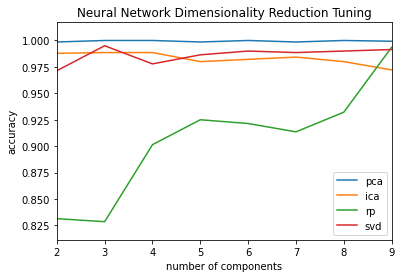

In [52]:
plt.figure()
plt.title('Neural Network Dimensionality Reduction Tuning')
plt.plot(size,train_pca, label="pca")
plt.plot(size,train_ica, label="ica")
plt.plot(size,train_rca, label="rp")
plt.plot(size,train_svd, label="svd")
plt.ylabel('accuracy')
plt.xlabel('number of components')
plt.legend()
plt.margins(0,0.1)
plt.show()
plt.close()

In [53]:
###### Neural Network clustering ###############
def plot_nnrdc_curve(title,x,y1,y2,y3):
    train1=[]
    train2=[]
    train3=[]
    test1=[]
    test2=[]
    test3=[]
    fraction = [i*10 for i in range(1,10)]
    for i in range(1,10):
        clf = MLPClassifier(hidden_layer_sizes=(26))   # change the hidden_layer_sizes = (26) or (16, 8) for parameter tuning
        X_train1, X_test1, y_train1, y_test1 = train_test_split(x, y1, random_state=0, test_size=1-i*10/100)
        X_train2, X_test2, y_train2, y_test2 = train_test_split(x, y2, random_state=0, test_size=1-i*10/100)
        X_train3, X_test3, y_train3, y_test3 = train_test_split(x, y3, random_state=0, test_size=1-i*10/100)
        
        clf.fit(X_train1, y_train1)    
        train_predict1 = clf.predict(X_train1)
        train1.append(metrics.accuracy_score(y_train1, train_predict1))
        test_predict1 = clf.predict(X_test1)
        test1.append(metrics.accuracy_score(y_test1, test_predict1))
        
        clf.fit(X_train2, y_train2)
        train_predict2 = clf.predict(X_train2)
        train2.append(metrics.accuracy_score(y_train2, train_predict2))
        test_predict2 = clf.predict(X_test2)
        test2.append(metrics.accuracy_score(y_test2, test_predict2))
        
        clf.fit(X_train3, y_train3)
        train_predict3 = clf.predict(X_train3)
        train3.append(metrics.accuracy_score(y_train3, train_predict3))
        test_predict3 = clf.predict(X_test3)
        test3.append(metrics.accuracy_score(y_test3, test_predict3))
    plt.figure()
    plt.title('Neural Network After Clustering with '+ title)
    
    plt.plot(fraction,train1, label="Original Training Set", linestyle='-', color='b')
    plt.plot(fraction,train2, label="KMemas Training Set", linestyle='-', color='g')
    plt.plot(fraction,train3, label="EM Training Set", linestyle='-', color='r')
    plt.plot(fraction,test1, label="Original Testing Set", linestyle=':', color='b')
    plt.plot(fraction,test2, label="KMemas Testing Set", linestyle=':', color='g')
    plt.plot(fraction,test3, label="EM Testing Set", linestyle=':', color='r')
    plt.ylabel('accuracy')
    plt.xlabel('percentage of trainning data size')
    plt.legend()
    plt.margins(0,0.1)
    plt.show()
    plt.close()

In [55]:
X_pca = PCA(n_components=2,random_state=10).fit_transform(X_train)  
KM_pca = KMeans(n_clusters=2, random_state=10).fit(X_pca)
EM_pca =  GaussianMixture(n_components=2, random_state=10).fit(X_pca)
KM_pca_labels = KM_pca.labels_
EM_pca_labels = EM_pca.predict(X_pca)

In [57]:
X_ica = FastICA(n_components=2,random_state=10).fit_transform(X_train)  
KM_ica = KMeans(n_clusters=2, random_state=10).fit(X_ica)
EM_ica =  GaussianMixture(n_components=2, random_state=10).fit(X_ica)
KM_ica_labels = KM_ica.labels_
EM_ica_labels = EM_ica.predict(X_ica)   

In [58]:
X_rp = SparseRandomProjection(n_components=18,random_state=10).fit_transform(X_train)  
KM_rp = KMeans(n_clusters=18, random_state=10).fit(X_rp)
EM_rp =  GaussianMixture(n_components=18, random_state=10).fit(X_rp)
KM_rp_labels = KM_rp.labels_
EM_rp_labels = EM_rp.predict(X_rp)

/Users/zhujingyao/Anaconda/anaconda3/envs/mlhw1/lib/python3.8/site-packages/sklearn/random_projection.py:376: DataDimensionalityWarning: The number of components is higher than the number of features: n_features < n_components (10 < 18).The dimensionality of the problem will not be reduced.
  warnings.warn(


In [59]:
X_svd = SVD(n_components=3,random_state=10).fit_transform(X_train)  
KM_svd = KMeans(n_clusters=3, random_state=10).fit(X_svd)
EM_svd =  GaussianMixture(n_components=3, random_state=10).fit(X_svd)
KM_svd_labels = KM_svd.labels_
EM_svd_labels = EM_svd.predict(X_svd) 

/Users/zhujingyao/Anaconda/anaconda3/envs/mlhw1/lib/python3.8/site-packages/sklearn/neural_network/_multilayer_perceptron.py:692: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(
/Users/zhujingyao/Anaconda/anaconda3/envs/mlhw1/lib/python3.8/site-packages/sklearn/neural_network/_multilayer_perceptron.py:692: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(
/Users/zhujingyao/Anaconda/anaconda3/envs/mlhw1/lib/python3.8/site-packages/sklearn/neural_network/_multilayer_perceptron.py:692: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(
/Users/zhujingyao/Anaconda/anaconda3/envs/mlhw1/lib/python3.8/site-packages/sklearn/neural_network/_multilayer_perceptron.py:692: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached 

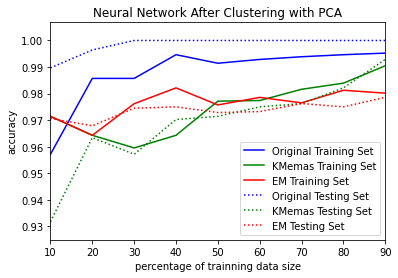

In [60]:
plot_nnrdc_curve('PCA',X_pca,y_train,KM_pca_labels,EM_pca_labels)

/Users/zhujingyao/Anaconda/anaconda3/envs/mlhw1/lib/python3.8/site-packages/sklearn/neural_network/_multilayer_perceptron.py:692: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(
/Users/zhujingyao/Anaconda/anaconda3/envs/mlhw1/lib/python3.8/site-packages/sklearn/neural_network/_multilayer_perceptron.py:692: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(
/Users/zhujingyao/Anaconda/anaconda3/envs/mlhw1/lib/python3.8/site-packages/sklearn/neural_network/_multilayer_perceptron.py:692: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(
/Users/zhujingyao/Anaconda/anaconda3/envs/mlhw1/lib/python3.8/site-packages/sklearn/neural_network/_multilayer_perceptron.py:692: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached 

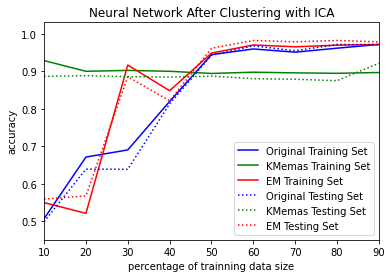

In [61]:
plot_nnrdc_curve('ICA',X_ica,y_train,KM_ica_labels,EM_ica_labels)

/Users/zhujingyao/Anaconda/anaconda3/envs/mlhw1/lib/python3.8/site-packages/sklearn/neural_network/_multilayer_perceptron.py:692: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(
/Users/zhujingyao/Anaconda/anaconda3/envs/mlhw1/lib/python3.8/site-packages/sklearn/neural_network/_multilayer_perceptron.py:692: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(
/Users/zhujingyao/Anaconda/anaconda3/envs/mlhw1/lib/python3.8/site-packages/sklearn/neural_network/_multilayer_perceptron.py:692: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(
/Users/zhujingyao/Anaconda/anaconda3/envs/mlhw1/lib/python3.8/site-packages/sklearn/neural_network/_multilayer_perceptron.py:692: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached 

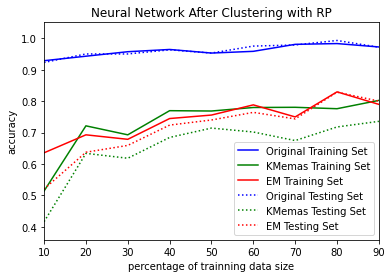

In [62]:
plot_nnrdc_curve('RP',X_rp,y_train,KM_rp_labels,EM_rp_labels)

/Users/zhujingyao/Anaconda/anaconda3/envs/mlhw1/lib/python3.8/site-packages/sklearn/neural_network/_multilayer_perceptron.py:692: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(
/Users/zhujingyao/Anaconda/anaconda3/envs/mlhw1/lib/python3.8/site-packages/sklearn/neural_network/_multilayer_perceptron.py:692: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(
/Users/zhujingyao/Anaconda/anaconda3/envs/mlhw1/lib/python3.8/site-packages/sklearn/neural_network/_multilayer_perceptron.py:692: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(
/Users/zhujingyao/Anaconda/anaconda3/envs/mlhw1/lib/python3.8/site-packages/sklearn/neural_network/_multilayer_perceptron.py:692: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached 

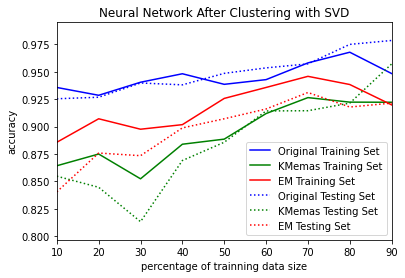

In [63]:
plot_nnrdc_curve('SVD',X_svd,y_train,KM_svd_labels,EM_svd_labels)